In [1]:
from tqdm import tqdm
import sys
import yaml
from pathlib import Path
from easydict import EasyDict
import numpy as np

from pcdet.datasets import KittiDataset

import pandas_profiling
import pandas as pd

from matplotlib.ticker import PercentFormatter
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()

/mnt/data/anaconda3/envs/shag_st/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_cfg_dir = '/mnt/data/shag01/kitti_stats/OpenPCDet/tools/cfgs/dataset_configs/kitti_dataset.yaml'
pcdet_root_dir = Path('/mnt/data/shag01/kitti_stats/OpenPCDet/')
save_plots_dir = '/mnt/data/shag01/kitti_stats/OpenPCDet/kitti_stats'
class_names = ['Car', 'Pedestrian', 'Cyclist']

In [3]:
dataset_cfg = EasyDict(yaml.load(open(dataset_cfg_dir)))
data_path = pcdet_root_dir / 'data' / 'kitti'
save_path = pcdet_root_dir / 'data' / 'kitti'

/tmp/ipykernel_10909/2781967634.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dataset_cfg = EasyDict(yaml.load(open(dataset_cfg_dir)))


In [4]:
kitti_train = KittiDataset(dataset_cfg=dataset_cfg, class_names=class_names, root_path=data_path)
infos_train = kitti_train.get_infos()

train sample_idx: 000000
train sample_idx: 000003
train sample_idx: 000007
train sample_idx: 000009
train sample_idx: 000010
train sample_idx: 000011
train sample_idx: 000012
train sample_idx: 000013
train sample_idx: 000014
train sample_idx: 000016
train sample_idx: 000017
train sample_idx: 000018
train sample_idx: 000022
train sample_idx: 000026
train sample_idx: 000029
train sample_idx: 000030
train sample_idx: 000032
train sample_idx: 000034
train sample_idx: 000036
train sample_idx: 000038
train sample_idx: 000041
train sample_idx: 000043
train sample_idx: 000044
train sample_idx: 000045
train sample_idx: 000046
train sample_idx: 000049
train sample_idx: 000051
train sample_idx: 000054
train sample_idx: 000055
train sample_idx: 000056
train sample_idx: 000057
train sample_idx: 000060
train sample_idx: 000064
train sample_idx: 000067
train sample_idx: 000068
train sample_idx: 000069
train sample_idx: 000070
train sample_idx: 000071
train sample_idx: 000072
train sample_idx: 000073


In [7]:
# kitti_val = KittiDataset(dataset_cfg=dataset_cfg, class_names=class_names, training=False, root_path=data_path)
# infos_val = kitti_val.get_infos()
# infos = infos_train + infos_val
# len(infos)

In [5]:
per_img_infos = []
per_obj_infos = []

for info in tqdm(infos_train):
    
    annos = info['annos']
    num_gts = annos['gt_boxes_lidar'].shape[0]
    
    lidar_idx = info['point_cloud']['lidar_idx']
    
    img_info = {}
    img_info['lidar_idx'] = lidar_idx
    img_info['num_gts'] = num_gts
    img_info['img_height'] = info['image']['image_shape'][0]
    img_info['img_width'] = info['image']['image_shape'][1]
        
    for i in range(num_gts):
        obj_info = {}
        obj_info['lidar_idx'] = lidar_idx
        
        
        for key, val in annos.items():
            if val.ndim == 2:  # split columns with 2D elements
                for j in range(val.shape[-1]):
                    new_key = key + f'_{j}'
                    obj_info[new_key] = val[i, j]
            else:
                obj_info[key] = val[i]
            
        per_obj_infos.append(obj_info)
    
    per_img_infos.append(img_info)

100%|██████████| 3712/3712 [00:00<00:00, 7510.86it/s]


In [6]:
per_obj_infos[0]

{'lidar_idx': '000000',
 'name': 'Pedestrian',
 'truncated': 0.0,
 'occluded': 0.0,
 'alpha': -0.2,
 'bbox_0': 712.4,
 'bbox_1': 143.0,
 'bbox_2': 810.73,
 'bbox_3': 307.92,
 'dimensions_0': 1.2,
 'dimensions_1': 1.89,
 'dimensions_2': 0.48,
 'location_0': 1.84,
 'location_1': 1.47,
 'location_2': 8.41,
 'rotation_y': 0.01,
 'score': -1.0,
 'difficulty': 0,
 'index': 0,
 'gt_boxes_lidar_0': 8.731380462646484,
 'gt_boxes_lidar_1': -1.8559175729751587,
 'gt_boxes_lidar_2': -0.6546993851661682,
 'gt_boxes_lidar_3': 1.2,
 'gt_boxes_lidar_4': 0.48,
 'gt_boxes_lidar_5': 1.89,
 'gt_boxes_lidar_6': -1.5807963267948966,
 'num_points_in_gt': 377}

In [7]:
per_img_infos_pd = pd.DataFrame.from_dict(per_img_infos)
per_obj_infos_pd = pd.DataFrame.from_dict(per_obj_infos)
new_colnames = ['lidar_idx', 'name', 'truncated', 'occluded', 'alpha (radian)', 'bbox_left (pixel)',
                'bbox_top (pixel)', 'bbox_right (pixel)', 'bbox_bottom (pixel)', 'dimensions_height (meters)',
                'dimensions_width (meters)', 'dimensions_length (meters)', 'location_x (meter)',
                'rotation_y (meters)', 'rotation_z (meters)', 'rotation_y (radian)', 'score', 'difficulty', 'index',
                'loc_x (meter)', 'loc_y (meter)', 'loc_z (meter)', 'dim_x (meter)', 'dim_y (meter)',
                'dim_z (meter)', 'rotation_y_lidar (radian)', 'num_points_in_gt']
per_obj_infos_pd.columns = new_colnames
per_obj_infos_pd = per_obj_infos_pd.drop(columns=['lidar_idx', 'index'])
report_img = pandas_profiling.ProfileReport(per_img_infos_pd, minimal=True)
report_obj = pandas_profiling.ProfileReport(per_obj_infos_pd, minimal=True)

In [8]:
area = per_obj_infos_pd['dimensions_height (meters)'] * per_obj_infos_pd['dimensions_width (meters)']
per_obj_infos_pd['area (meter^2)'] = area
width = per_obj_infos_pd['bbox_right (pixel)'] - per_obj_infos_pd['bbox_left (pixel)']
height = per_obj_infos_pd['bbox_bottom (pixel)'] - per_obj_infos_pd['bbox_top (pixel)']
per_obj_infos_pd['dimensions_height (pixels)'] = height
per_obj_infos_pd['area (pixel^2)'] = height * width

In [9]:
per_obj_infos_pd

,name,truncated,occluded,alpha (radian),bbox_left (pixel),bbox_top (pixel),bbox_right (pixel),bbox_bottom (pixel),dimensions_height (meters),dimensions_width (meters),...,loc_y (meter),loc_z (meter),dim_x (meter),dim_y (meter),dim_z (meter),rotation_y_lidar (radian),num_points_in_gt,area (meter^2),dimensions_height (pixels),area (pixel^2)
0,Pedestrian,0.0,0.0,-0.20,712.400024,143.000000,810.729980,307.920013,1.20,1.89,...,-1.855918,-0.654699,1.20,0.48,1.89,-1.580796,377,2.2680,164.920013,16216.578125
1,Car,0.0,0.0,1.55,614.239990,181.779999,727.309998,284.769989,4.15,1.57,...,-0.981780,-0.909490,4.15,1.73,1.57,-3.190796,674,6.5155,102.989990,11645.079102
2,Car,0.0,0.0,-1.56,564.619995,174.589996,616.429993,224.740005,3.20,1.61,...,0.708958,-0.688423,3.20,1.66,1.61,0.019204,182,5.1520,50.150009,2598.271973
3,Car,0.0,0.0,1.71,481.589996,180.089996,512.549988,202.419998,3.70,1.40,...,7.453393,-0.676632,3.70,1.51,1.40,-3.120796,20,5.1800,22.330002,691.336670
4,Car,0.0,0.0,1.64,542.049988,175.550003,565.270020,193.789993,4.05,1.46,...,4.733361,-0.369830,4.05,1.66,1.46,-3.130796,5,5.9130,18.239990,423.533142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19695,Car,0.0,0.0,2.06,498.890015,186.740005,759.599976,333.700012,3.99,1.46,...,-0.423110,-0.916730,3.99,1.74,1.46,-3.670796,1560,5.8254,146.960007,38313.937500
19696,Car,0.0,1.0,1.82,654.409973,185.960007,752.380005,245.050003,4.29,1.42,...,-2.670077,-0.999280,4.29,1.68,1.42,-3.520796,68,6.0918,59.089996,5789.048828
19697,Car,0.0,2.0,1.76,729.469971,184.250000,786.080017,224.100006,3.80,1.36,...,-5.579149,-0.976757,3.80,1.40,1.36,-3.530796,16,5.1680,39.850006,2255.910645
19698,Van,0.0,1.0,1.60,801.700012,162.110001,837.520020,202.619995,5.64,2.52,...,-13.955256,-0.348510,5.64,2.10,2.52,-3.450796,75,14.2128,40.509995,1451.068359


In [10]:
per_obj_infos_pd.columns

Index(['name', 'truncated', 'occluded', 'alpha (radian)', 'bbox_left (pixel)',
       'bbox_top (pixel)', 'bbox_right (pixel)', 'bbox_bottom (pixel)',
       'dimensions_height (meters)', 'dimensions_width (meters)',
       'dimensions_length (meters)', 'location_x (meter)',
       'rotation_y (meters)', 'rotation_z (meters)', 'rotation_y (radian)',
       'score', 'difficulty', 'loc_x (meter)', 'loc_y (meter)',
       'loc_z (meter)', 'dim_x (meter)', 'dim_y (meter)', 'dim_z (meter)',
       'rotation_y_lidar (radian)', 'num_points_in_gt', 'area (meter^2)',
       'dimensions_height (pixels)', 'area (pixel^2)'],
      dtype='object')

In [11]:
# per_obj_infos_pd.to_pickle(os.path.join(pcdet_root_dir,'kitti_stats/kitti_per_obj_infos_pd'))
per_obj_infos_pd.to_pickle(os.path.join(save_plots_dir, 'kitti_per_obj_infos_pd'))

In [12]:
sep_dfs = {}
for (name, df) in per_obj_infos_pd.groupby('name'):
    sep_dfs[name] = df

In [13]:
kitti_car_length = sep_dfs['Car']['dim_x (meter)']
kitti_car_width = sep_dfs['Car']['dim_y (meter)']
kitti_car_height = sep_dfs['Car']['dim_z (meter)']
kitti_car_depths = sep_dfs['Car']['loc_x (meter)']
kitti_car_rot = sep_dfs['Car']['rotation_y_lidar (radian)']

kitti_ped_length = sep_dfs['Pedestrian']['dim_x (meter)']
kitti_ped_width = sep_dfs['Pedestrian']['dim_y (meter)']
kitti_ped_height = sep_dfs['Pedestrian']['dim_z (meter)']
kitti_ped_depths = sep_dfs['Pedestrian']['loc_x (meter)']
kitti_ped_rot = sep_dfs['Pedestrian']['rotation_y_lidar (radian)']

kitti_cyc_length = sep_dfs['Cyclist']['dim_x (meter)']
kitti_cyc_width = sep_dfs['Cyclist']['dim_y (meter)']
kitti_cyc_height = sep_dfs['Cyclist']['dim_z (meter)']
kitti_cyc_depths = sep_dfs['Cyclist']['loc_x (meter)']
kitti_cyc_rot = sep_dfs['Cyclist']['rotation_y_lidar (radian)']

print("Car Height min/max:", kitti_car_height.min(), kitti_car_height.max(), 
    "Car Width min/max:", kitti_car_width.min(), kitti_car_width.max(),
    "Car Length min/max:", kitti_car_length.min(), kitti_car_length.max(),
    "Car Rotation min/max:", kitti_car_rot.min(), kitti_car_rot.max())

print("Ped Height min/max:", kitti_ped_height.min(), kitti_ped_height.max(), 
    "Ped Width min/max:", kitti_ped_width.min(), kitti_ped_width.max(),
    "Ped Length min/max: ", kitti_ped_length.min(), kitti_ped_length.max(),
    "Ped Rotation min/max:", kitti_ped_rot.min(), kitti_ped_rot.max())

print("Cyc Height min/max :", kitti_cyc_height.min(), kitti_cyc_height.max(), 
    "Cyc Width min/max:", kitti_cyc_width.min(), kitti_cyc_width.max(),
    "Cyc Length min/max: ", kitti_cyc_length.min(), kitti_cyc_length.max(),
    "Cyc Rotation min/max:", kitti_cyc_rot.min(), kitti_cyc_rot.max())

Car Height min/max: 1.14 2.48 Car Width min/max: 1.14 1.99 Car Length min/max: 2.23 6.67 Car Rotation min/max: -4.710796326794897 1.5692036732051036
Ped Height min/max: 1.14 2.01 Ped Width min/max: 0.3 0.94 Ped Length min/max:  0.2 1.28 Ped Rotation min/max: -4.710796326794897 1.5692036732051036
Cyc Height min/max : 1.41 2.09 Cyc Width min/max: 0.34 0.89 Cyc Length min/max:  1.32 2.17 Cyc Rotation min/max: -4.7007963267948965 1.5692036732051036


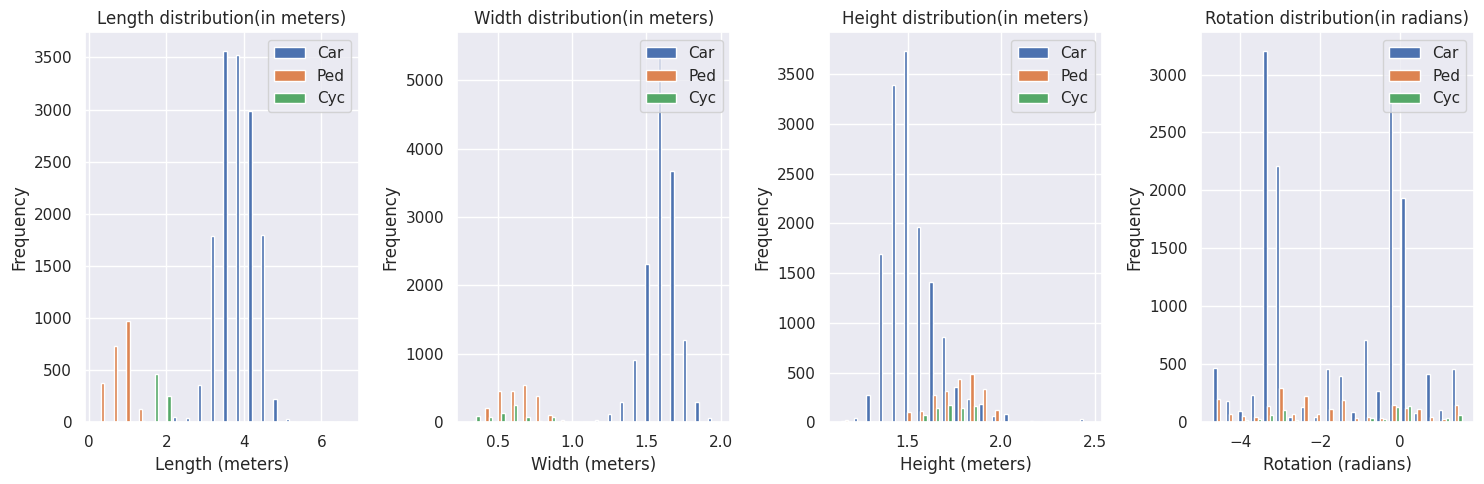

In [19]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(15,5))

# =======================3D Bounding Box Length Distribution=======================
ax1.hist([kitti_car_length, kitti_ped_length, kitti_cyc_length], bins=20, label=['Car', 'Ped', 'Cyc'])
ax1.set_title("Length distribution(in meters)")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Length (meters)")
ax1.legend(loc='upper right')

# =======================3D Bounding Box Width Distribution=======================
ax2.hist([kitti_car_width, kitti_ped_width, kitti_cyc_width], bins=20, label=['Car', 'Ped', 'Cyc'])
ax2.set_title("Width distribution(in meters)")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Width (meters)")
ax2.legend(loc='upper right')

# =======================3D Bounding Box Height Distribution=======================
ax3.hist([kitti_car_height, kitti_ped_height, kitti_cyc_height], bins=20, label=['Car', 'Ped', 'Cyc'])
ax3.set_title("Height distribution(in meters)")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Height (meters)")
ax3.legend(loc='upper right')

# =======================3D Bounding Box Rotation Distribution=======================
ax4.hist([kitti_car_rot, kitti_ped_rot, kitti_cyc_rot], bins=20, label=['Car', 'Ped', 'Cyc'])
ax4.set_title("Rotation distribution(in radians)")
ax4.set_ylabel("Frequency")
ax4.set_xlabel("Rotation (radians)")
ax4.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(save_plots_dir, 'dim_distribution.png'))

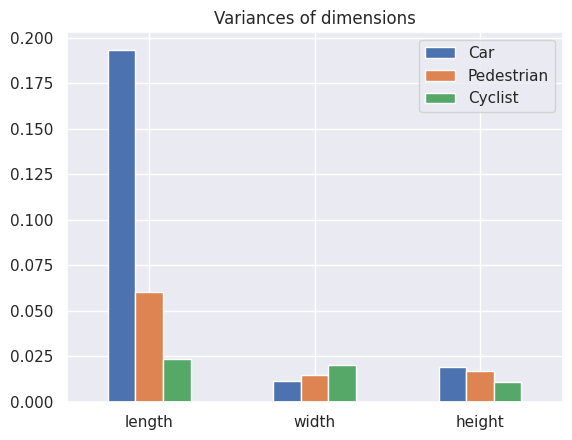

In [23]:
# Variances in dimensions of different classes
from collections import defaultdict
var_dict = defaultdict(dict)

# dim_x - length, dim_y - width, dim_z = height
dimensions = ['dim_x (meter)', 'dim_y (meter)', 'dim_z (meter)']
for class_name in class_names:
    for dim in dimensions:
        var_dict[class_name][dim] = np.var(sep_dfs[class_name][dim])

var_df = pd.DataFrame(var_dict)
ax = var_df.plot(kind='bar', title='Variances of dimensions')
ax.set_xticks([0,1,2], ['length', 'width', 'height'], rotation=0)
ax.figure.savefig(os.path.join(save_plots_dir, "dim_var_distribution.png"))

In [19]:
# Remove extra classes 
for class_name in list(sep_dfs.keys()):
    if class_name not in class_names:
        sep_dfs.pop(class_name)
sep_dfs.keys()

dict_keys(['Car', 'Cyclist', 'Pedestrian'])

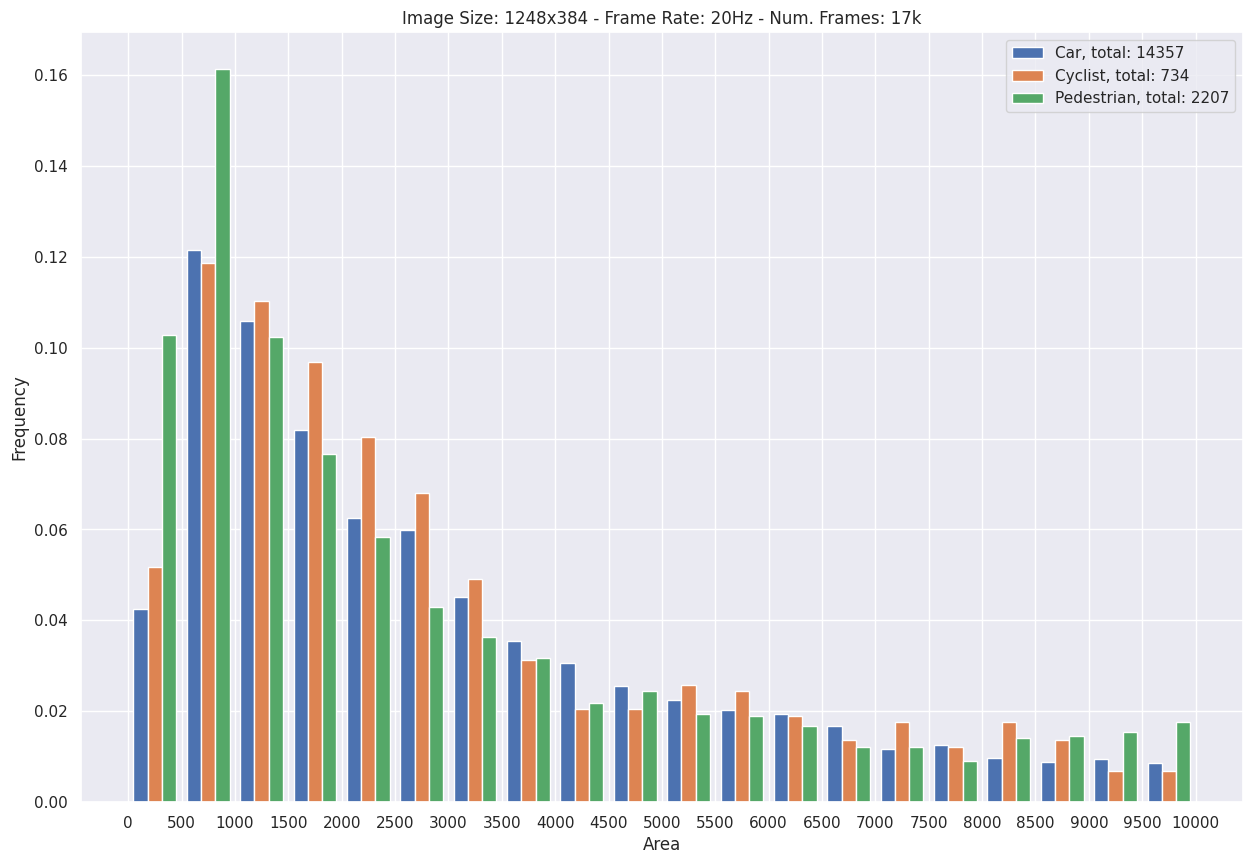

In [20]:
f, ax = plt.subplots(1,1,figsize=(15,10))
vectors = [df['area (pixel^2)'].to_numpy() for df in sep_dfs.values()]
vec_weights = [[] for x in range(len(vectors))]
x_range = (0, 10000)
labels = [k +  ', total: {}'.format(len(v)) for k, v in sep_dfs.items()]
for i in range(len(vectors)):
    if 0 < len(vectors[i]):
        vec_weights[i] = np.ones(len(vectors[i])) / len(vectors[i])
    else:
        vec_weights[i] = 0

# plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
arr, bins, patches = plt.hist(vectors, bins=20, label=labels, weights=vec_weights, range=x_range);
ax.set_xticks(bins)
# ax.set(xlabel='Height')
ax.set(xlabel='Area')
ax.set(ylabel='Frequency')

ax.set_title('Image Size: 1248x384 - Frame Rate: 20Hz - Num. Frames: 17k')
plt.legend()
plt.savefig(os.path.join(save_plots_dir,"area_distribution.png"))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


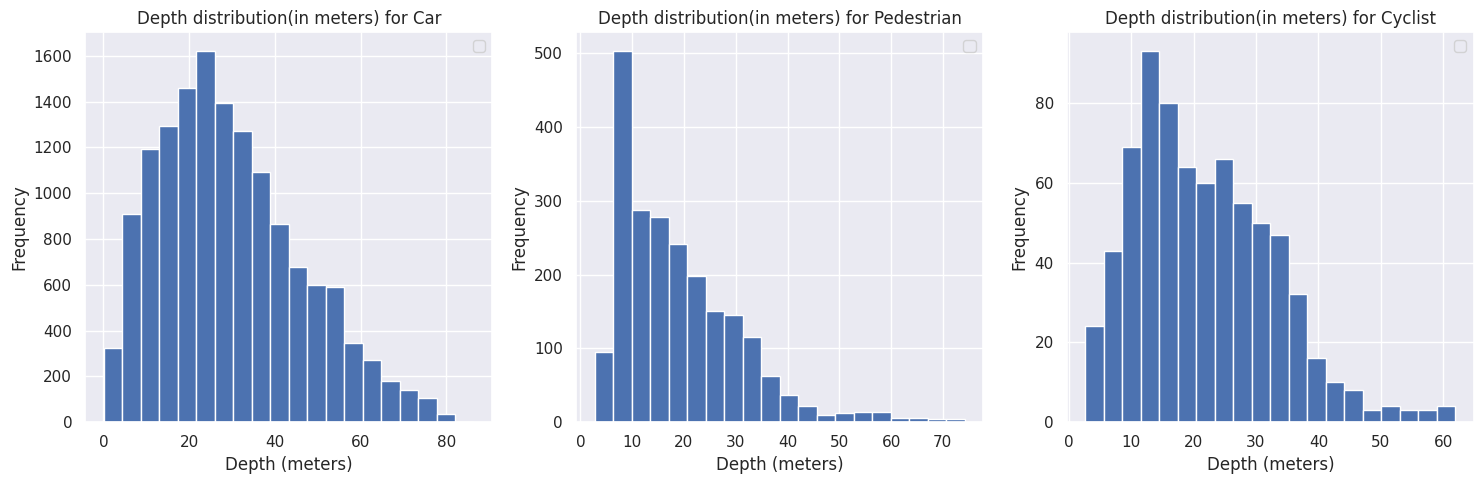

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,5))

ax1.hist(kitti_car_depths, bins=20)
ax1.set_title("Depth distribution(in meters) for Car")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Depth (meters)")
ax1.legend(loc='upper right')

ax2.hist(kitti_ped_depths, bins=20)
ax2.set_title("Depth distribution(in meters) for Pedestrian")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Depth (meters)")
ax2.legend(loc='upper right')

ax3.hist(kitti_cyc_depths, bins=20)
ax3.set_title("Depth distribution(in meters) for Cyclist")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Depth (meters)")
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(save_plots_dir, 'depth_distribution.png'))